# FVI Clustering

This notebook filters frames based on FVI scores, creates embeddings for the selected frames, and clusters the embeddings.

In [1]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import random


# Add the path to the scripts directory
import sys
sys.path.append('../scripts')
print(np.__version__)

1.26.4


## Load FVI Scores

Load the FVI scores from the `fvi_scores.json` file.

In [2]:
def load_fvi_scores(directory):
    fvi_scores = {}
    for root, _, files in os.walk(directory):
        for file in files:
            if file == 'fvi_scores.json':
                filepath = os.path.join(root, file)
                with open(filepath, 'r') as f:
                    scores = json.load(f)
                    fvi_scores[root] = scores
    return fvi_scores

fvi_scores = load_fvi_scores('../output/ground_truth')
fvi_scores

{'../output/ground_truth/408/VID002C/preds': [92.44998647917694,
  81.05553651663777,
  89.19080670113932,
  84.23182296495784,
  79.66178506661774,
  89.65489389877163,
  79.0885579587844,
  75.88807547961669,
  72.62919523166975,
  84.23775875461075,
  100.11493395093461,
  98.96464014990404,
  93.79765455489812,
  92.69304181005174,
  97.94896630388705,
  98.32090316916337,
  74.53187237685633,
  92.01086892318754,
  81.55366331440912,
  94.45104552094699,
  87.19518335321051,
  85.56868586112562,
  94.97368056467013,
  80.3305670339753,
  80.39278574598593,
  85.63293758829018,
  85.01176389182852,
  84.61678320522472,
  78.90500617831546,
  85.9709253178073,
  95.1892851112981,
  87.67553820764375,
  88.23831367382311,
  87.18371407550839,
  80.820789404707,
  79.98749902328488,
  68.46897107449476,
  79.88742078700501,
  86.53900854527974,
  91.49316914393118,
  79.04429138147802,
  88.88194417315589,
  88.90444308357148,
  72.15261603018979,
  96.66954018717581,
  77.85884663928

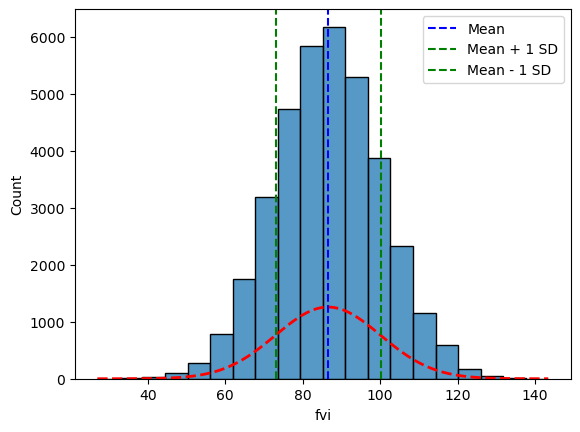

In [3]:
# create a chart to show the distribution of the fvi scores
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import norm

# Example fvi_scores dictionary for demonstration purposes
fvi_scores_list = []
for root, scores in fvi_scores.items():
    for score in scores:
        fvi_scores_list.append(score)

df = pd.DataFrame(fvi_scores_list, columns=['fvi'])

sns.histplot(df, x='fvi', bins=20)

# add a bell curve
mu, std = norm.fit(df['fvi'])
min_fvi, max_fvi = df['fvi'].min(), df['fvi'].max()
x = np.linspace(min_fvi, max_fvi, 100)
y = norm.pdf(x, mu, std) * len(df) * (x[1] - x[0])
plt.plot(x, y, 'r--', linewidth=2)

# Add standard deviation lines
plt.axvline(mu, color='blue', linestyle='--', label='Mean')
plt.axvline(mu + std, color='green', linestyle='--', label='Mean + 1 SD')
plt.axvline(mu - std, color='green', linestyle='--', label='Mean - 1 SD')
plt.legend()

plt.show()

## Filter Frames

Filter frames with FVI scores above a certain threshold.
low FVI scores => redundant

In [4]:
threshold = 60 # 
selected_frames_images = []
selected_frames = []
for directory, scores in fvi_scores.items():
    for i, score in enumerate(scores):
        if score > threshold:
            # Adjusting the directory path to replace "../output/ground_truth" with "/data"
            adjusted_directory = directory.replace("../output", "../data")
            adjusted_directory = adjusted_directory.replace("\\", "/")
            adjusted_directory_image = directory.replace("../output/ground_truth", "../output/video_frames")

            # Adjusting the directory path to replace "/preds" with ""
            adjusted_directory_image = adjusted_directory_image.replace("preds", "")

            frame_path = os.path.join(adjusted_directory, f'{i+1:04d}.json')
            image_path = os.path.join(adjusted_directory_image, f'{i+1:04d}.jpg')
            image_path = image_path.replace("\\", "/")
            frame_path = frame_path.replace("\\", "/")
            selected_frames_images.append(image_path)
            selected_frames.append(frame_path)

print(len(selected_frames))
print(selected_frames[:5])
print(selected_frames_images[:5])

35481
['../data/ground_truth/408/VID002C/preds/0001.json', '../data/ground_truth/408/VID002C/preds/0002.json', '../data/ground_truth/408/VID002C/preds/0003.json', '../data/ground_truth/408/VID002C/preds/0004.json', '../data/ground_truth/408/VID002C/preds/0005.json']
['../output/video_frames/408/VID002C/0001.jpg', '../output/video_frames/408/VID002C/0002.jpg', '../output/video_frames/408/VID002C/0003.jpg', '../output/video_frames/408/VID002C/0004.jpg', '../output/video_frames/408/VID002C/0005.jpg']


In [5]:
sys.path.append('../scripts')

from coco_converter import convert_selected_frames_to_coco

convert_selected_frames_to_coco(selected_frames, '../output/selected_frames_coco.json')

COCO file created at: ../output/selected_frames_coco.json


## Create Embeddings

Use a pre-trained ResNet model from PyTorch to create embeddings for the selected frames.

In [6]:
import torch
print(torch.cuda.is_available()) # run nvidia-smi to check if GPU is available

True


In [14]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import fiftyone as fo
import fiftyone.brain as fob
from sklearn.cluster import KMeans

sys.path.append('../scripts')

from embeddings_generator import process_image, generate_embeddings
from coco_converter import convert_selected_images_to_coco
image_paths = selected_frames_images
# Generate embeddings for all images
embeddings = generate_embeddings(image_paths)


# Perform KMeans Clustering on Embeddings
valid_embeddings = [embedding for embedding in embeddings if embedding is not None]  # Filter out None values

# inertia 
k_values = range(1, 15)
inertia_values = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto")
    kmeans.fit(valid_embeddings)
    inertia_values.append(kmeans.inertia_)
    
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow method for optimal number of clusters')
plt.grid(True)
plt.show()


n_clusters = 50  # of clusters  from 2 to 15. n_ too high if only we have 1 point in cluster.
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto")
cluster_labels = kmeans.fit_predict(valid_embeddings)
clusters = kmeans.labels_
cluster_dict = []
for idx, cluster in enumerate(cluster_labels):
    # cluster_dict[cluster]['embedding'].append(valid_embeddings[idx])
    cluster_dict.append({"cluster": cluster, "embedding": valid_embeddings[idx], "file_path": image_paths[idx]})

# print(cluster_dict[:2])

# print("Print Centroids")
representatives = []
centroids = kmeans.cluster_centers_
m = 2 # 2~3

# find the optimal number of clusters



# The sampled points that we want
closest_points = {}

for cluster_id, centroid in enumerate(centroids):
    distances = np.linalg.norm(embeddings - centroid, axis=1)
    closest_indices = np.argsort(distances)[:m]
    closest_points[cluster_id] = closest_indices
    

# Find the closest images to each centroid
representatives = []  # List to store representative images for each cluster

# Iterate over each cluster and find the closest points
for cluster_id, centroid in enumerate(centroids):
    # Compute distances from all valid embeddings to the centroid
    distances = np.linalg.norm(np.array(valid_embeddings) - centroid, axis=1)
    
    # Get indices of the closest images (m closest points)
    closest_indices = np.argsort(distances)[:m]
    
    # Create a dictionary for this cluster with image paths and embeddings
    cluster_representative = {
        "cluster": cluster_id,
        # "centroid": centroid.tolist(),  # Convert centroid to list for better readability
        "closest_images": [
            {
                "file_path": image_paths[idx],
                # "embedding": valid_embeddings[idx].tolist()  # Convert embedding to list
            }
            for idx in closest_indices
        ]
    }
    
    representatives.append(cluster_representative)

# Print representatives for all clusters
print(representatives)

# print representations from cluster 0
for rep in representatives:
    if rep['cluster'] == 0:
        print(rep)



selected_representatives_images = []
for rep in representatives:
    for path in rep["closest_images"]:
        selected_representatives_images.append(path['file_path'])

print(len(selected_representatives_images))

# Convert list to a dictionary with keys and values being the same
my_dict = {item: item for item in selected_representatives_images}

# Write the dictionary to a JSON file
with open('../output/selected_representatives_image.json', 'w') as json_file:
    json.dump(my_dict, json_file)

# => 

convert_selected_images_to_coco(selected_representatives_images, '../output/selected_representatives_coco.json')

# create a new folder and copy images for the selected representatives

# for sample, label in zip(dataset, cluster_labels): 
#     print(label)
#     sample["cluster"] = label
#     sample.save()
    

# Use the Array Number => Find the Matching Images => Generate COCO file => Visualize

KeyboardInterrupt: 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7a6fe9896480>
Traceback (most recent call last):
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/jayjpark/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has

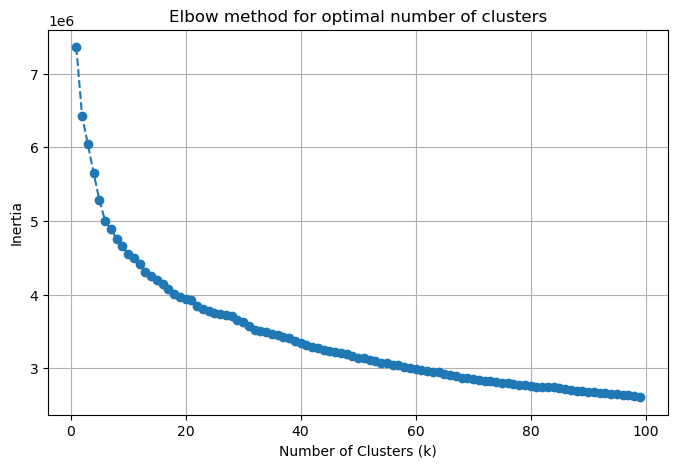

In [18]:
# inertia 
k_values = range(1, 100)
inertia_values = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto")
    kmeans.fit(valid_embeddings)
    inertia_values.append(kmeans.inertia_)
    
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow method for optimal number of clusters')
plt.grid(True)
plt.show()


In [19]:
from kneed import KneeLocator

knee_locator = KneeLocator(k_values, inertia_values, curve="convex", direction="decreasing")
optimal_k = knee_locator.knee
print(f"Optimal number of clusters: {optimal_k}")

Optimal number of clusters: 18


In [8]:
import fiftyone as fo
import fiftyone.brain as fob


# dataset_rest = fo.Dataset.from_images(selected_frames_images)
dataset = fo.Dataset.from_dir(
    data_path="../output/selected_representatives_image.json",
    labels_path="../output/selected_representatives_coco.json",
    dataset_type=fo.types.COCODetectionDataset,
)

# for filepath, embedding in zip(image_paths, embeddings):
#     if embedding is not None:  # Ensure valid embedding exists
#         sample = fo.Sample(filepath=filepath)
#         sample["embedding"] = embedding.tolist()  # Convert NumPy array to list for storage in FiftyOne
#         dataset.add_sample(sample)

fob.compute_visualization(
    dataset,
    embeddings="resnet101",
    method="umap",
    brain_key="umap_resnet101_test",
    patches_field="detections"
)

 100% |█████████████████| 100/100 [3.4s elapsed, 0s remaining, 26.1 samples/s]      
Computing patch embeddings...
 100% |█████████████████| 100/100 [15.1s elapsed, 0s remaining, 5.6 samples/s]      
Generating visualization...
UMAP( verbose=True)
Sat Dec 14 00:03:57 2024 Construct fuzzy simplicial set
Sat Dec 14 00:03:57 2024 Finding Nearest Neighbors
Sat Dec 14 00:03:58 2024 Finished Nearest Neighbor Search
Sat Dec 14 00:04:00 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sat Dec 14 00:04:02 2024 Finished embedding


In [9]:
print(dataset)

Name:        2024.12.14.00.03.32
Media type:  image
Num samples: 100
Persistent:  False
Tags:        []
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    detections:       fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    segmentations:    fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


In [11]:
sys.path.append('../scripts')

from embeddings_generator import process_image, generate_embeddings
from coco_converter import categories

print(dataset)

# Define the directory where you want to export the dataset
export_dir = "../output/selected_representatives_dataset"

# dataset_rest = fo.Dataset.from_images(selected_frames_images)
dataset = fo.Dataset.from_dir(
    data_path="../output/selected_representatives_image.json",
    labels_path="../output/selected_representatives_coco.json",
    dataset_type=fo.types.COCODetectionDataset,
)


# Export the dataset to COCO format
dataset.export(
    export_dir=export_dir,
    dataset_type=fo.types.COCODetectionDataset,
    categories=categories
    # label_field="ground_truth"  # Replace with your actual label field name
)

# Export the dataset to the specified directory in a desired format
dataset.export(
    export_dir=export_dir,
    dataset_type=fo.types.ImageDirectory  # or fo.types.VideoDirectory for video datasets
)


Name:        2024.12.14.00.03.32
Media type:  image
Num samples: 100
Persistent:  False
Tags:        []
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    detections:       fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    segmentations:    fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
 100% |█████████████████| 100/100 [3.6s elapsed, 0s remaining, 25.3 samples/s]      
Found multiple fields ['detections', 'segmentations'] with compatible type (<class 'fiftyone.core.labels.Detections'>, <class 'fiftyone.core.labels.Polylines'>, <class 'fiftyone.core.l

In [13]:
session = fo.launch_app(dataset)
session.wait()

Notebook sessions cannot wait


# SAMPLING BY CLUSTERS

# k-MEANS SET THE NUMBER OF CLUSTERS BY WHAT WE WANT, Allow it with to chajnge k-means value ;find points closest to cetroid

number of points closest to coentroid

i
# ITERATE CLUSTERS AND CHOOSE FRAMES THAT ARE CLOSEST TO THE CETREOID;u,i